# Subject level windowed mean analysis

This notebook demonstrates a simple analysis of epoched EEG data. It introduces the concept of a windowed mean, where two conditions are compared by taking the mean of the signal in a certain time window in relevant sensors and comparing the means. This includes some basic plotting and statistical testing using t-tests.

## Setting up Python
First of all, we need to make sure that we are working in the `env` environment.


1. Run `bash env_to_ipynb_kernel.sh` from the `EEG` folder if you have not already done so. This will make sure that the `env` environment is available as a kernel in this notebook.

2. Press `Select Kernel`, then `Jupyter kernel...` and select `env`. If `env` does not show up, press the little refresh symbol!

**Note:** You might have to install the Jupyter extension for VScode to be able to select the kernel.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import mne

## Loading the data
First, we load in preprocessed EEG data from a single subject.

In [2]:
# load in the data
data_path = Path("/work/EEG_lab/example_data")

epochs = mne.read_epochs(data_path / f"Group1-epo.fif", verbose=False, preload=True)

# only keep eeg channels
epochs.pick(["eeg"])

Number of events,240
Events,Correct/wNeg: 19Correct/wNeu/iNeg: 8Correct/wPos: 18Image/wNeg: 20Image/wNeu/iNeg: 8Image/wNeu/iPos: 12Image/wPos: 20Incorrect/wNeg: 2Incorrect/wNeu/iPos: 12Incorrect/wPos: 1Wait/wNeg: 20Wait/wNeu/iNeg: 8Wait/wNeu/iPos: 12Wait/wPos: 20Word/wNeg: 20Word/wNeu: 20Word/wPos: 20
Time range,-0.200 – 0.496 s
Baseline,-0.200 – 0.000 s


## Single participant analysis
In this note book we will compare the correct and incorrect button presses for one participant. We will do this by taking the mean of the signal in a certain time window and comparing the means. We will also plot the data and perform a t-test to see if the difference is significant.


### Extracting data from the epochs

In [3]:
# extract the trials you are interested in
epochs_incorrect = epochs["Incorrect"] # all the button presses for incorrect trials
epochs_correct = epochs["Correct"] # all the button presses for correct trials

Now we have our two conditions: Correct and incorrect button presses. One of the simplest way in which we can determine whether the signal in our two conditions are statistically significant is by:

1. Segmenting our data to channels and a time window chosen a priori.

2. Taking the mean of that window time window across channels.

3. Running statistical tests on the windowed means from the two conditions.

In an experiment with multiple participants we would also average over trials from individual participants, in order to only have one data point per participant (and thereby avoid multiple comparisons). However, since we have one participant (for now), we can keep one dimension of the individual data, i.e. the trials.

If you are conducting a windowed mean analysis, you should rely on previous literature to determine which channels and time windows to use. 

**Note:** The time window and channels used in this example are arbitrarily chosen for the purpose of demonstrating how to calculate the windowed mean and run a statistical test on it.

### Preparing the data for t-test
The aim is to conduct a t-test on the averaged data, to establish whether the means of the two conditions (correct and incorrect) are different.

We can use the `get_data()` function to get the numerical values of the signal for the t-test. tmin and tmax are used to define the time window, and the picks are the channels that we expect to see an effect in.

In [4]:
# chosen channels
picks = ["Fz", "Cz", "Pz", "Oz"]

# time window in seconds
tmin = 0.2
tmax = 0.4

In [5]:
# HINT 
# you can use the following to get the channel names
channel_names = epochs_incorrect.ch_names
print(channel_names)

['F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']


In [6]:
# extract the data
data_incorrect = epochs_incorrect.get_data(picks = picks, tmin = tmin, tmax = tmax)
data_correct = epochs_correct.get_data(picks = picks, tmin = tmin, tmax = tmax)

Investigating the resulting data; how many dimensions does the data have? What do you think they represent (i.e. which dimension is channels, trials, etc.)? Is there a difference in the number of trials between the two conditions?

In [7]:
print(data_incorrect.shape)
print(data_correct.shape)

(15, 4, 50)
(45, 4, 50)


Now we can average over the time window and channels to get one data point per trial. We can use the `np.mean()` function to do this, and specify the axis over which to average. 

In [8]:
data_incorrect_mean = np.mean(data_incorrect, axis=2) # averaging over the third dimension of the data (time)
print(data_incorrect_mean.shape)

data_incorrect_mean = np.mean(data_incorrect_mean, axis=1) # averaging over the second dimension of the data (channels)
print(data_incorrect_mean.shape)

# you can also do this in one line
data_correct_mean = np.mean(data_correct, axis=(1,2)) # averaging over the second and third dimension of the data (channels and time)
print(data_correct_mean.shape)

(15, 4)
(15,)
(45,)


### Running the t-test
Now that we have one numerical value per trial, we can compare the means of the two conditions using a t-test. We can use the `scipy.stats.ttest_ind()` function to do this.

In [9]:
from scipy import stats

In [10]:
stats.ttest_ind(data_correct_mean, data_incorrect_mean)

TtestResult(statistic=-0.6223877700899523, pvalue=0.5361262213332723, df=58.0)

### Plotting
Now lets create a plot of the time courses averaged over time and channels, where we also plot the time window that we used for the t-test.

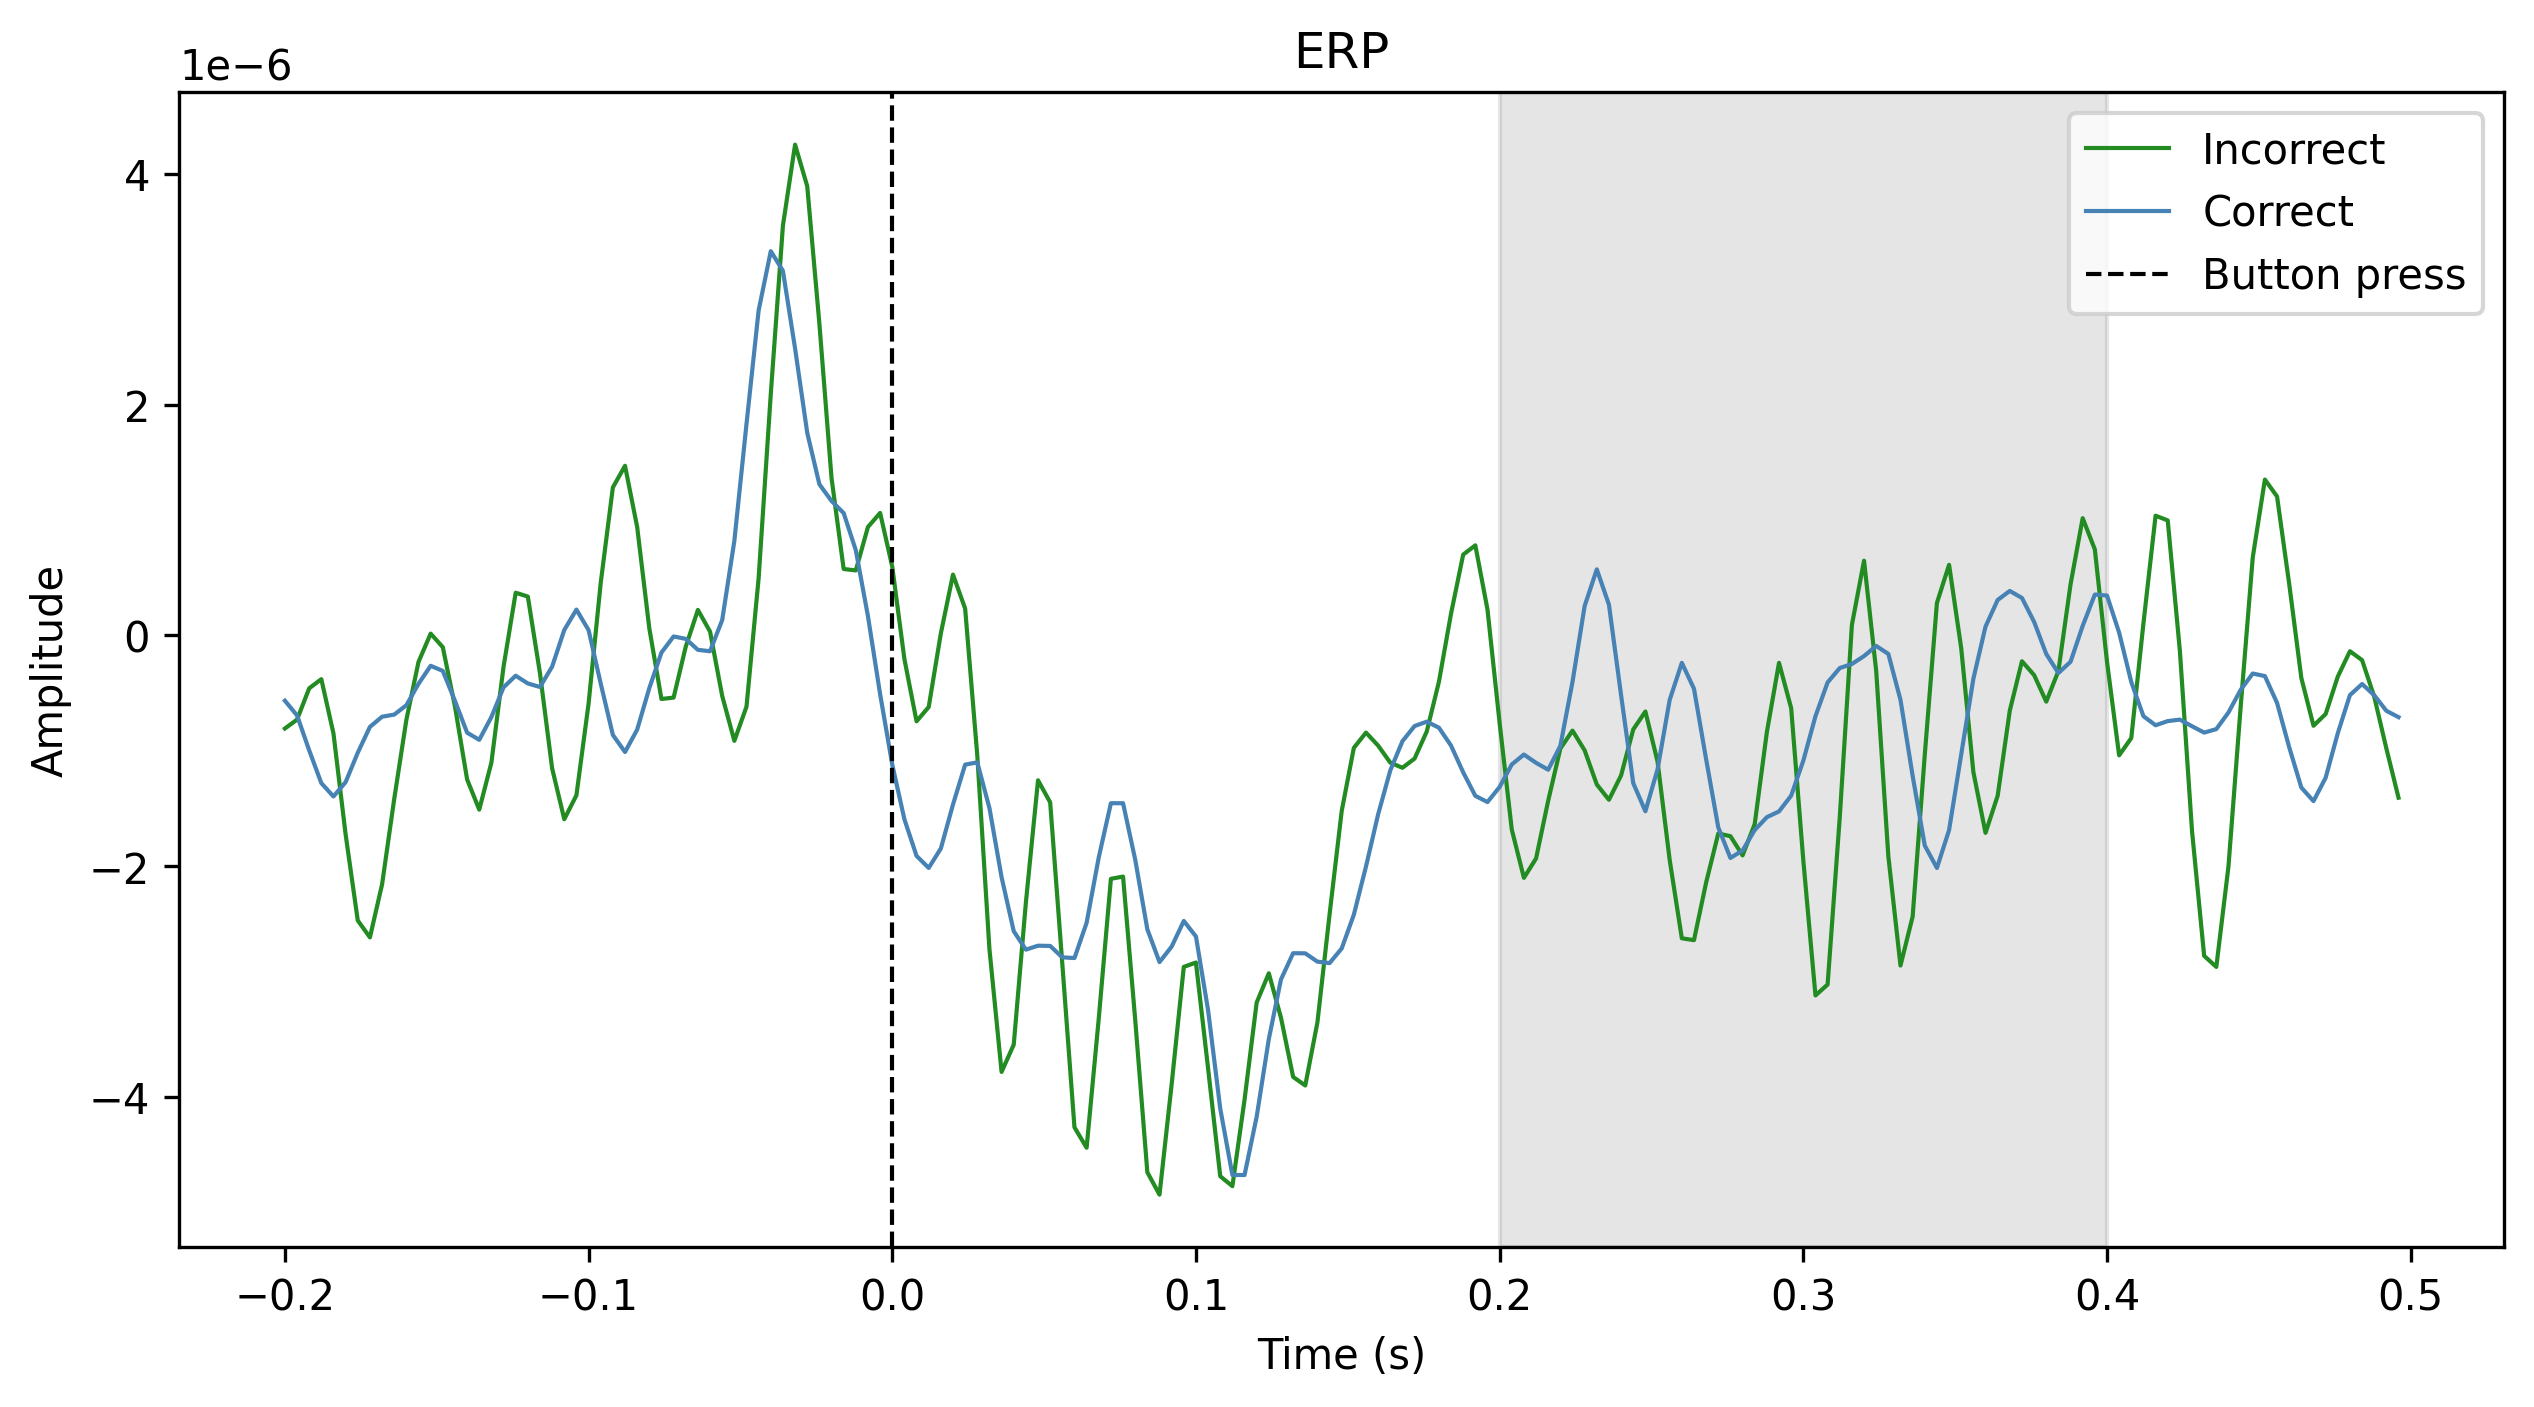

In [15]:
plot_data_incorrect = epochs_incorrect.get_data(copy = True).mean(axis=(0, 1)) # mean over channels and trials 
plot_data_correct = epochs_correct.get_data(copy = True).mean(axis=(0, 1)) # mean over channels and trials 

times = epochs_incorrect.times

fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

# plot the time course
ax.plot(times, plot_data_incorrect.T, label="Incorrect", linewidth=1, color="forestgreen")
ax.plot(times, plot_data_correct.T, label="Correct", linewidth=1, color="steelblue")

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", label = "Button press", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP")
ax.legend(loc = "upper right")